In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('EDA/HI-Medium_Trans.csv', low_memory=False)

df.columns = [
    'timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
    'amount_received', 'receiving_currency', 'amount_paid', 'payment_currency',
    'payment_format', 'is_laundering'
]

# Minimal preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['tx_hour'] = df['timestamp'].dt.hour
df['tx_day'] = df['timestamp'].dt.dayofweek
df['tx_month'] = df['timestamp'].dt.month

# Encode categorical fields
from sklearn.preprocessing import LabelEncoder

for col in ['from_bank', 'to_bank', 'payment_format']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Feature set (minimal, no leaky features)
features = ['amount_received', 'amount_paid', 'tx_hour', 'tx_day', 'tx_month', 'from_bank', 'to_bank', 'payment_format']
target = 'is_laundering'

df_model = df[features + [target]].dropna()


Prepare tensors with gaussian noise

In [2]:
from sklearn.preprocessing import StandardScaler
import torch

X = StandardScaler().fit_transform(df_model[features])
y = df_model[target].astype(np.float32).values.reshape(-1, 1)

# Add small Gaussian noise to features
noise = np.random.normal(0, 0.01, X.shape)
X += noise

# Tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


/Users/vaibhavbeohar/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch.utils.data import TensorDataset, DataLoader, random_split

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
train_dl = DataLoader(train_ds, batch_size=1024, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1024)
test_dl = DataLoader(test_ds, batch_size=1024)


Simple regularized model

In [6]:
import torch.nn as nn

class AMLNet(nn.Module):
    def __init__(self, input_dim):
        super(AMLNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)  # No sigmoid here
        )

    def forward(self, x):
        return self.model(x)


model = AMLNet(X.shape[1])


Training loop and early stopping rounds

Epoch 1 - Train Loss: 0.6194, Val Loss: 0.5948
Epoch 2 - Train Loss: 0.6008, Val Loss: 0.5919
Epoch 3 - Train Loss: 0.5980, Val Loss: 0.5926
Epoch 4 - Train Loss: 0.5957, Val Loss: 0.5904
Epoch 5 - Train Loss: 0.5955, Val Loss: 0.5846
Epoch 6 - Train Loss: 0.5932, Val Loss: 0.5890
Epoch 7 - Train Loss: 0.5944, Val Loss: 0.5806
Epoch 8 - Train Loss: 0.5927, Val Loss: 0.5887
Epoch 9 - Train Loss: 0.5914, Val Loss: 0.5900
Epoch 10 - Train Loss: 0.5904, Val Loss: 0.5771
Epoch 11 - Train Loss: 0.5948, Val Loss: 0.5846
Epoch 12 - Train Loss: 0.5893, Val Loss: 0.5824
Epoch 13 - Train Loss: 0.5921, Val Loss: 0.5793
Epoch 14 - Train Loss: 0.5899, Val Loss: 0.5778
Epoch 15 - Train Loss: 0.5929, Val Loss: 0.5833
Early stopping triggered.


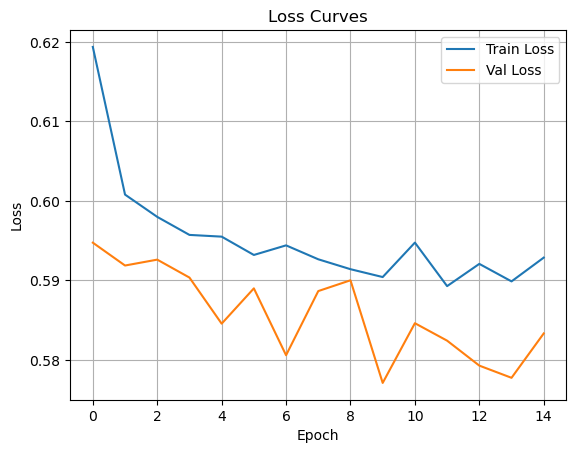

In [7]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Calculate positive class weight
positive_weight = (df_model['is_laundering'] == 0).sum() / (df_model['is_laundering'] == 1).sum()
pos_weight_tensor = torch.tensor([positive_weight], dtype=torch.float32)

# Use BCEWithLogitsLoss for class weighting
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

# loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization

def train(model, train_dl, val_dl, epochs=50, patience=5):
    best_val_loss = float('inf')
    best_model = None
    early_stopping_counter = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        train_loss = total_loss / len(train_dl.dataset)
        train_losses.append(train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_dl:
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item() * xb.size(0)

        val_loss = val_loss / len(val_dl.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered.")
                break

    # Restore best model
    model.load_state_dict(best_model)

    # Plot
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.grid()
    plt.show()

train(model, train_dl, val_dl, epochs=50, patience=5)


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

model.eval()
y_true, y_probs = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)
        probs = torch.sigmoid(logits)
        y_probs.extend(probs.view(-1).tolist())
        y_true.extend(yb.view(-1).tolist())

# Binary predictions
y_pred = [1 if p > 0.5 else 0 for p in y_probs]

# Evaluation
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1 Score :", f1_score(y_true, y_pred))
print("ROC AUC  :", roc_auc_score(y_true, y_probs))


Accuracy : 0.8766607692680272
Precision: 0.007839038411288215
Recall   : 0.8756345177664975
F1 Score : 0.015538965645373779
ROC AUC  : 0.9384484840793539


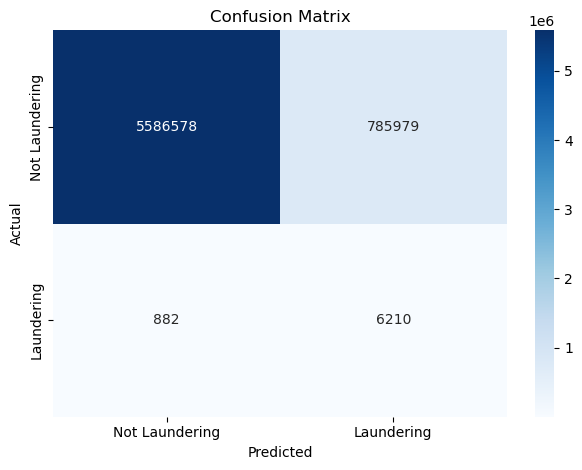

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Laundering", "Laundering"], yticklabels=["Not Laundering", "Laundering"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# 6,379,649 --> total transactions
# 5,586,578 --> true negatives
# 785,979 --> false positive --> 12.32009% 
# 6210 -> true positive  --> 0.09% 
# 882 --> false negative

In [ ]:
# torch.save(best_model, "model_weights/best_aml_model_regularized.pth")

# model.load_state_dict(torch.load("best_aml_model.pth"))
# model.eval()


NameError: name 'best_model' is not defined

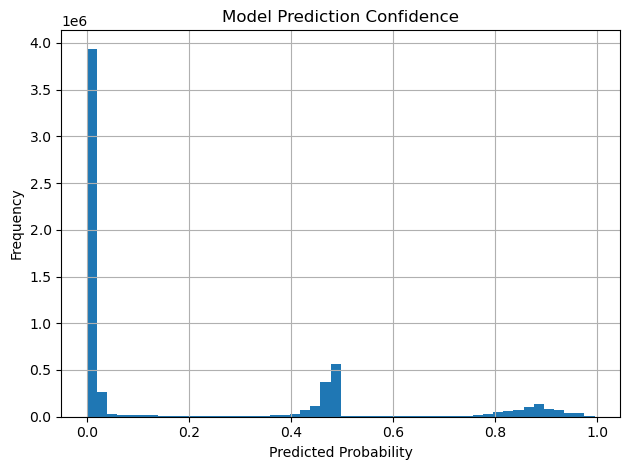

In [11]:
plt.hist(y_probs, bins=50)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Model Prediction Confidence")
plt.grid(True)
plt.tight_layout()
plt.show()


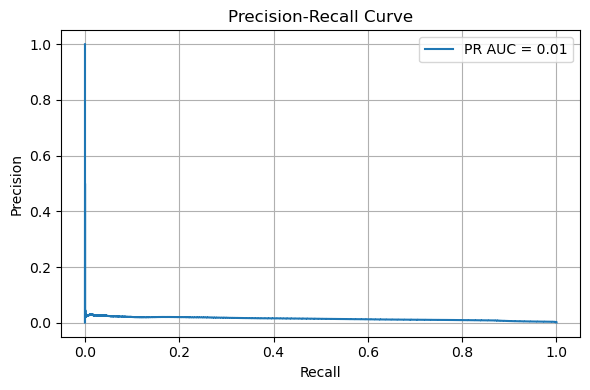

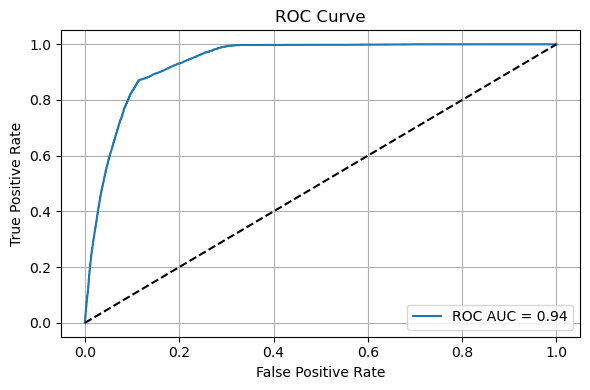

In [13]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

# Wrap model in a function that takes numpy and outputs probabilities
def model_predict(X_numpy):
    with torch.no_grad():
        X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
        logits = model(X_tensor)
        probs = torch.sigmoid(logits).numpy().ravel()
    return probs

from sklearn.metrics import roc_auc_score
result = permutation_importance(
    estimator=None,
    X=X,
    y=y.ravel(),
    scoring="roc_auc",
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    estimator_score=model_predict
)

# Plot
sorted_idx = result.importances_mean.argsort()[::-1]
plt.barh(np.array(features)[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance (by AUC)")
plt.tight_layout()
plt.show()


### Create new thresholds to improve F1, PR-AUC etc

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)


# 🔍 Step 1: Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# 🔍 Step 2: Compute F1 score for each threshold
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

# 🔍 Step 3: Find the threshold with best F1 score
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]  # ✅ DEFINED HERE
print(f"Best threshold based on F1: {best_threshold:.4f}")

# 🔍 Step 4: Apply this threshold to generate predictions
y_pred_opt = [1 if p > best_threshold else 0 for p in y_probs]  # ✅ DEFINED HERE



# Print optimal threshold
print(f"Best threshold based on F1 score: {best_threshold:.4f}")

# Evaluate with optimal threshold
accuracy  = accuracy_score(y_true, y_pred_opt)
precision = precision_score(y_true, y_pred_opt, zero_division=0)
recall    = recall_score(y_true, y_pred_opt, zero_division=0)
f1        = f1_score(y_true, y_pred_opt, zero_division=0)
roc_auc   = roc_auc_score(y_true, y_probs)

print("\n📊 Evaluation with Optimal Threshold:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC AUC  : {roc_auc:.4f}")


Best threshold based on F1: 0.9446
Best threshold based on F1 score: 0.9446

📊 Evaluation with Optimal Threshold:
Accuracy : 0.9895
Precision: 0.0208
Recall   : 0.1839
F1 Score : 0.0374
ROC AUC  : 0.9384


<Figure size 600x400 with 0 Axes>

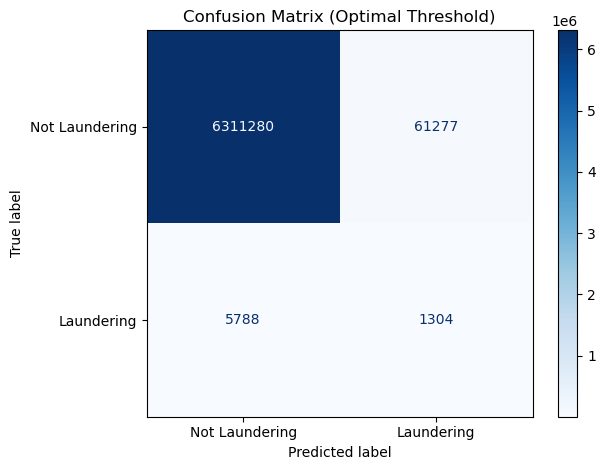

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Laundering", "Laundering"])

plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Optimal Threshold)")
plt.tight_layout()
plt.show()


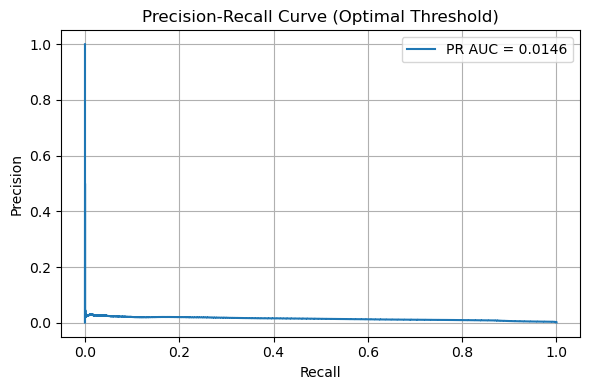

In [19]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, _ = precision_recall_curve(y_true, y_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Optimal Threshold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


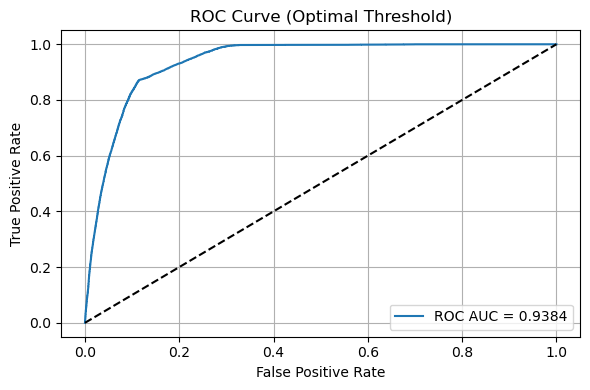

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Optimal Threshold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
